In [1]:
import numpy as np
import networkx as nx
import json

import tqdm as tqdm

from simplequantnetsim.protocols import MPC_protocol, MPG_protocol, SP_protocol
from simplequantnetsim.graph import network, set_edge_length, update_graph_params, reset_graph_state, reset_graph_usage, remove_nodes

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from networkx.drawing.layout import *
from networkx.readwrite import json_graph

# Helpers

## Draw network

In [2]:
# def read_network(file_path):
#     G = nx.Graph()
#     with open(file_path, 'r') as f:
#         lines = f.readlines()[1:]  # 跳过标题行
#         for line in lines:
#             parts = line.strip().split()
#             origen = int(parts[0])
#             destino = int(parts[1])
#             distancia = float(parts[2])
#             MTBF = float(parts[3])
#             MTTR = float(parts[4])
#             G.add_edge(origen, destino, distancia=distancia, MTBF=MTBF, MTTR=MTTR)
#     return G

# def draw_network(G, size="l"):
#     usage = nx.get_edge_attributes(G, 'distancia')
#     pos = nx.spring_layout(G)  # 使用 spring layout 进行布局

#     cmap = plt.cm.Blues
#     cmap.set_under(color="white")  # display zero fraction (under 0.0000001) as white

#     nc = nx.draw(
#         G,
#         pos=pos,
#         with_labels=draw_options[size]["with_labels"],
#         node_size=draw_options[size]["node_size"],
#         font_size=draw_options[size]["font_size"],
#         node_color="lightblue",
#         edge_color=list(usage.values()),
#         edge_cmap=cmap,
#         width=2,
#     )

#     # colorbar
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(usage.values()), vmax=max(usage.values())))
#     sm.set_array([])
#     cbar = plt.colorbar(sm)
#     cbar.set_label("Distance (Km)", rotation=270, fontsize=12, labelpad=15)

#     plt.show()

# # 定义绘图选项
# draw_options = {
#     "l": {
#         "with_labels": True,
#         "node_size": 1000,
#         "font_size": 10,
#         "label_offset": 0.25,
#         "label_size": 8
#     },
#     "m": {
#         "with_labels": True,
#         "node_size": 500,
#         "font_size": 8,
#         "label_offset": 0.35,
#         "label_size": 6
#     },
#     "s": {
#         "with_labels": False,
#         "node_size": 250,
#         "font_size": 0,
#         "label_offset": 0,
#         "label_size": 6
#     },
#     "xs": {
#         "with_labels": False,
#         "node_size": 80,
#         "font_size": 0,
#         "label_offset": 0,
#         "label_size": 4
#     }
# }


In [3]:
# # 读取文件路径
# files = {
#     "ARPAnet": "graphs/ARPAnet_distancia_MTBF_MTTR.txt",
#     "EON": "graphs/EON_distancia_MTBF_MTTR.txt",
#     "Eurocore": "graphs/Eurocore.txt",
#     "NSFnet": "graphs/NSFnet.txt",
#     "UKnet": "graphs/UKnet.txt",
#     "USnet": "graphs/USnet.txt"
# }

# # 绘制每个网络图
# for name, file_path in files.items():
#     G = read_network(file_path)
#     print(f"Drawing network for {name}")
#     draw_network(G, size="l")


Failed to read ARPAnet with encoding utf-8
Drawing network for ARPAnet using encoding latin-1


C:\Users\ROG\AppData\Local\Temp\ipykernel_35888\163028187.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


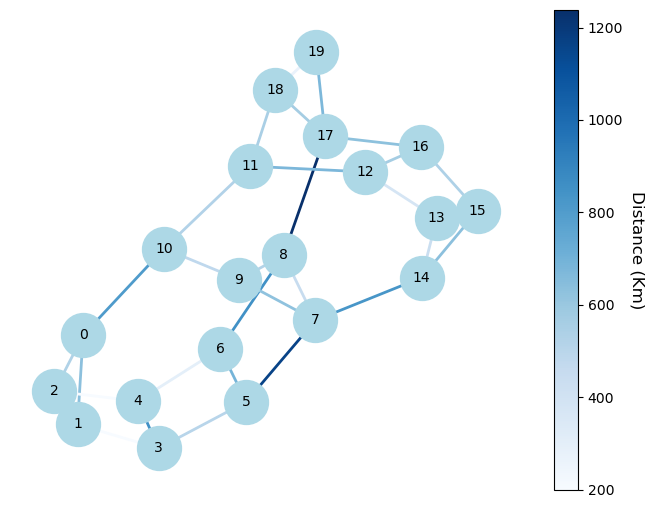

Failed to read EON with encoding utf-8
Drawing network for EON using encoding latin-1


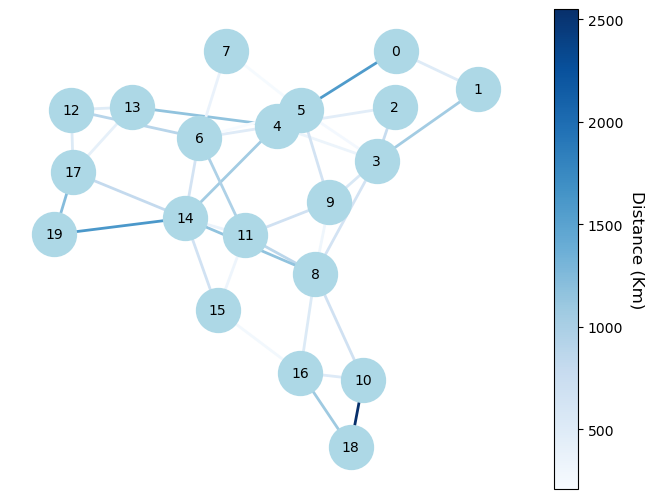

Failed to read Eurocore with encoding utf-8
Drawing network for Eurocore using encoding latin-1


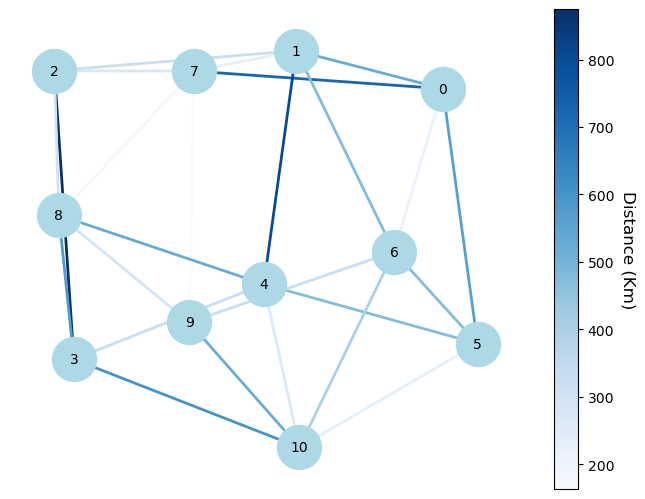

Failed to read NSFnet with encoding utf-8
Drawing network for NSFnet using encoding latin-1


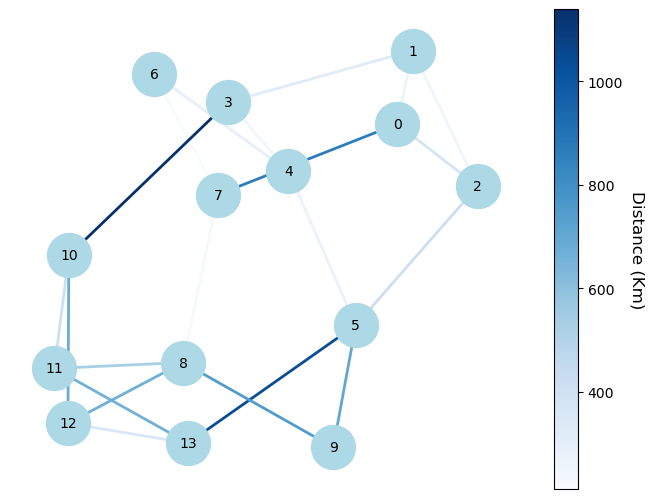

Failed to read UKnet with encoding utf-8
Drawing network for UKnet using encoding latin-1


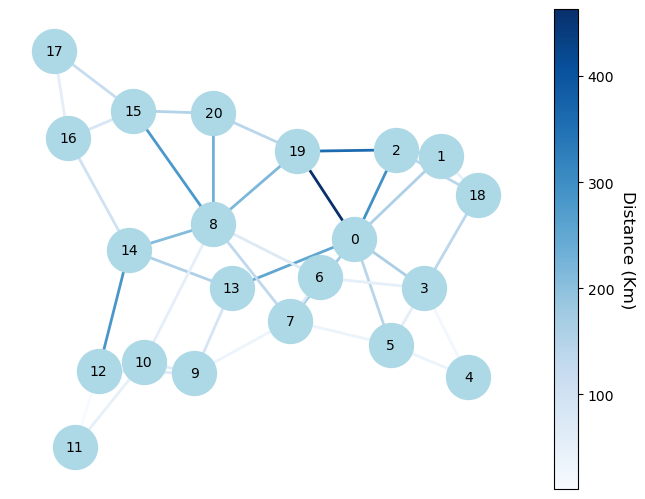

Failed to read USnet with encoding utf-8
Drawing network for USnet using encoding latin-1


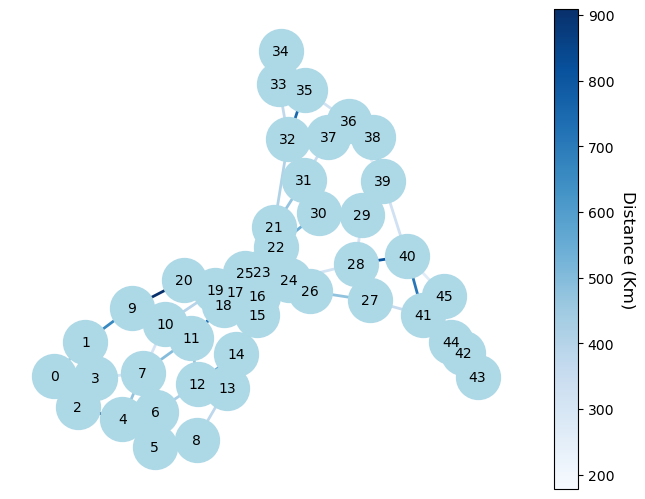

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def read_network(file_path, encoding='utf-8'):
    G = nx.Graph()
    with open(file_path, 'r', encoding=encoding) as f:
        lines = f.readlines()[1:]  # 跳过标题行
        for line in lines:
            parts = line.strip().split()
            origen = int(parts[0])
            destino = int(parts[1])
            distancia = float(parts[2])
            MTBF = float(parts[3])
            MTTR = float(parts[4])
            G.add_edge(origen, destino, distancia=distancia, MTBF=MTBF, MTTR=MTTR)
    return G

def draw_network(G, size="l"):
    usage = nx.get_edge_attributes(G, 'distancia')
    pos = nx.spring_layout(G)  # 使用 spring layout 进行布局

    cmap = plt.cm.Blues
    cmap.set_under(color="white")  # display zero fraction (under 0.0000001) as white

    nc = nx.draw(
        G,
        pos=pos,
        with_labels=draw_options[size]["with_labels"],
        node_size=draw_options[size]["node_size"],
        font_size=draw_options[size]["font_size"],
        node_color="lightblue",
        edge_color=list(usage.values()),
        edge_cmap=cmap,
        width=2,
    )

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(usage.values()), vmax=max(usage.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label("Distance (Km)", rotation=270, fontsize=12, labelpad=15)

    plt.show()

# 定义绘图选项
draw_options = {
    "l": {
        "with_labels": True,
        "node_size": 1000,
        "font_size": 10,
        "label_offset": 0.25,
        "label_size": 8
    },
    "m": {
        "with_labels": True,
        "node_size": 500,
        "font_size": 8,
        "label_offset": 0.35,
        "label_size": 6
    },
    "s": {
        "with_labels": False,
        "node_size": 250,
        "font_size": 0,
        "label_offset": 0,
        "label_size": 6
    },
    "xs": {
        "with_labels": False,
        "node_size": 80,
        "font_size": 0,
        "label_offset": 0,
        "label_size": 4
    }
}

# 读取文件路径
files = {
    "ARPAnet": "graphs/ARPAnet_distancia_MTBF_MTTR.txt",
    "EON": "graphs/EON_distancia_MTBF_MTTR.txt",
    "Eurocore": "graphs/Eurocore.txt",
    "NSFnet": "graphs/NSFnet.txt",
    "UKnet": "graphs/UKnet.txt",
    "USnet": "graphs/USnet.txt"
}

# 尝试不同的编码方式读取文件并绘制图
encodings = ['utf-8', 'latin-1', 'ISO-8859-1']
for name, file_path in files.items():
    for encoding in encodings:
        try:
            G = read_network(file_path, encoding=encoding)
            print(f"Drawing network for {name} using encoding {encoding}")
            draw_network(G, size="l")
            break  # 成功读取后跳出循环
        except UnicodeDecodeError:
            print(f"Failed to read {name} with encoding {encoding}")
